In [1]:
claude_api = "put your key here"

from anthropic import Anthropic

# Initialize Claude client
claude_client = Anthropic(api_key=claude_api)

def chat_completion_request_claude(prompt):
    """
    Send a chat completion request to Claude API
    
    Args:
        prompt (str): The user prompt to send to Claude
        
    Returns:
        str: The response content from Claude
    """
    response = claude_client.messages.create(
        model="claude-3-7-sonnet-20250219",  # You can change to other Claude models as needed
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=450,
    )
    
    if response.content:
        return response.content[0].text
    else:
        return None 


In [2]:
from getpass import getpass
model = "NousResearch/Meta-Llama-3-8B-Instruct"
base_url="http://localhost:8000/v1"

from openai import OpenAI
import re

client = OpenAI(
    api_key='put your key here',
)

def chat_completion_request_openai(prompt):
    messages = [
        {"role": "user", "content": prompt}
    ]

    chat_response = client.chat.completions.create(
    model='o1',
    messages=messages,
    temperature=1.0)
    if chat_response.choices:
        completion_text = chat_response.choices[0].message.content
    else:
        completion_text = None
    return completion_text

definitions = open("llm_as_a_judge_traces/definitions.txt", "r").read()

def openai_evaluator(trace, definitions=definitions, examples='', claude=False):
    prompt = (
    "Below I will provide a multiagent system trace. provide me an analysis of the failure modes and inefficiencies as I will say below. \n"
    "In the traces, analyze the system behaviour."
    "There are several failure modes in multiagent systems I identified. I will provide them below. Tell me if you encounter any of them, as a binary yes or no. \n"
    "Also, give me a one sentence (be brief) summary of the problems with the inefficiencies or failure modes in the trace. Only mark a failure mode if you can provide an example of it in the trace, and specify that in your summary at the end"
    "Also tell me whether the task is successfully completed or not, as a binary yes or no."
    "At the very end, I provide you with the definitions of the failure modes and inefficiencies. After the definitions, I will provide you with examples of the failure modes and inefficiencies for you to understand them better."
    "Tell me if you encounter any of them between the @@ symbols as I will say below, as a binary yes or no."
    "Here are the things you should answer. Start after the @@ sign and end before the next @@ sign (do not include the @@ symbols in your answer):"
    "*** begin of things you should answer *** @@"
    "A. Freeform text summary of the problems with the inefficiencies or failure modes in the trace: <summary>"
    "B. Whether the task is successfully completed or not: <yes or no>"
    "C. Whether you encounter any of the failure modes or inefficiencies:"
    "1.1 Poor task constraint compliance: <yes or no>"
    "1.2 Unaware of stopping conditions: <yes or no>"
    "1.3 Unbatched repetitive execution : <yes or no>"
    "1.4 Step repetition: <yes or no>"
    "1.5 Backtracking interruption: <yes or no>"
    "1.6 Disobey role specification : <yes or no>"
    "2.1 Conversation reset: <yes or no>"
    "2.2 Fail to elicit clarification from other agents: <yes or no>"
    "2.3 Derailment from task: <yes or no>"
    "2.4 Undetected conversation ambiguities and contradictions: <yes or no>"
    "2.5 Withholding relevant information: <yes or no>"
    "2.6 Ignoring suggestions from agents: <yes or no>"
    "2.7 Inconsistency between reasoning and action: <yes or no>"
    "3.1 Premature exit due to incomplete termination conditions: <yes or no>"
    "3.2 Lack of critical verification: <yes or no>"
    "3.3 Lack of result verification: <yes or no>"
    "@@*** end of your answer ***"
    "An example answer is: \n"
    "A. The task is not completed due to disobeying role specification as agents went rogue and started to chat with each other instead of completing the task. Agents derailed and verifier is not strong enough to detect it.\n"
    "B. no \n"
    "C. \n"
    "1.1 no \n"
    "1.2 no \n"
    "1.3 no \n"
    "1.4 no \n"
    "1.5 no \n"
    "1.6 yes \n"
    "2.1 no \n"
    "2.2 no \n"
    "2.3 yes \n"
    "2.4 no \n"
    "2.5 no \n"
    "2.6 yes \n"
    "2.7 no \n"
    "3.1 no \n"
    "3.2 yes \n"
    "3.3 no \n"   
    "Here is the trace: \n"
    f"{trace}"
    "Also, here are the explanations (definitions) of the failure modes and inefficiencies: \n"
    f"{definitions} \n"
    "Here are some examples of the failure modes and inefficiencies: \n"
    f"{examples}"
)
    if claude:
        return chat_completion_request_claude(prompt)
    else:
        return chat_completion_request_openai(prompt)
    
    # "2.5 Withholding relevant information: Failure to share or communicate important information that an agent has obtained before and did not share that information with other agents. Whereas if shared, (like a solution plan or new data), it could have avoided some failures or made the system more efficient. \n"
        # "2.4 Undetected conversation ambiguities and contradictions: Failure to recognize unclear or conflicting information within the dialogue, leading to misunderstandings or erroneous conclusions. \n"


In [3]:
examples = open("llm_as_a_judge_traces/examples.txt", "r").read()

## LLM As a Judge Experiments

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("annotations.csv")
df['Blurring roles'].fillna('false', inplace=False).str.lower().value_counts()

Blurring roles
false    91
Name: count, dtype: int64

In [6]:
import numpy as np

In [7]:
counter = np.zeros(5)
metagpt_counter = 0
appworld_counter = 0
def fetch_raw_trace(path):

    global metagpt_counter, appworld_counter
    try:
        
        if path.startswith('https://github.com/LakshyAAAgrawal/MultiAgentFailureTaxonomyAnnotations/blob/main/'):
            counter[0] += 1
            path = path.replace('https://github.com/LakshyAAAgrawal/MultiAgentFailureTaxonomyAnnotations/blob/main/', 'annotated_traces/')
            if 'metagpt' in path and path.endswith('.json'):
                metagpt_counter += 1
                path = path.replace('.json', '_newer.json')
            with open(path) as f:
                return f.read()
        elif path.startswith('https://github.com/melissa-pan/ChatDev/blob/4o/'):
            counter[1] += 1
            path = path.replace('https://github.com/melissa-pan/ChatDev/blob/4o/', 'annotated_traces/ChatDev/')
            path = path.replace('%20', ' ')
            with open(path) as f:
                return f.read()
        elif path.startswith('https://github.com/LakshyAAAgrawal/AppWorld/blob/main/'):
            counter[2] += 1
            path = path.replace('https://github.com/LakshyAAAgrawal/AppWorld/blob/main/', 'annotated_traces/AppWorld/')
            with open(path) as f:
                return f.read()
        elif path.startswith('https://github.com/LakshyAAAgrawal/AppWorld/blob/f5f35c9eeba75dc33fe0573d479c920d7f969500/'):
            counter[3] += 1
            path = path.replace('https://github.com/LakshyAAAgrawal/AppWorld/blob/f5f35c9eeba75dc33fe0573d479c920d7f969500/', 'annotated_traces/AppWorld/')
            if '#L' in path:
                path = path.split('#L')[0]
            with open(path) as f:
                return f.read()
        elif path.startswith('https://github.com/LakshyAAAgrawal/AppWorld/tree/f5f35c9eeba75dc33fe0573d479c920d7f969500/'):
            counter[4] += 1
            path = path.replace('https://github.com/LakshyAAAgrawal/AppWorld/tree/f5f35c9eeba75dc33fe0573d479c920d7f969500/', 'annotated_traces/AppWorld/')
            if '#L' in path:
                path = path.split('#L')[0]
            with open(path) as f:
                return f.read()
        else:
            print(path)
            raise Exception("Not implemented")
    except Exception as e:
        appworld_counter += 1
        print(path)
        assert False
        return None
    

In [8]:
df = df[~df['Path in GH repo to the execution trace'].isna()] #30,60,90,121,153 ==> 30,30,30,31,32 ==> 28,30,30,31,32

In [9]:
len(df)

153

In [10]:
# Remove the 28th and 18th rows of the dataframe
# Create a copy of the dataframe with the specified rows dropped
df = df.drop([17, 27])

In [11]:
# df = df[df['MultiAgentSystem Name'] != 'AppWorld']

In [11]:
df['full_trace'] = df['Path in GH repo to the execution trace'].apply(lambda x: fetch_raw_trace(x))

In [12]:
import json

def obj_to_str(d, indent=0):
    s = ""
    if type(d) == dict:
        for k, v in d.items():
            if type(v) != str:
                s1 = obj_to_str(v, indent+1)
            else:
                s1 = str(v)
            if '\n' in s1:
                lines = s1.split('\n')
                joined = ("  "*(indent+1)) + ("\n" + ("  "*(indent+1))).join(lines)
                s += f"{k}:\n{joined}\n"
            else:
                s += f"{k}: {s1}\n"
        
        return s
    elif type(d) == list:
        v = d[0]
        if type(v) == str:
            s = "\n".join(d)
            return s
        else:
            for v in d:
                s1 = obj_to_str(v, indent+1)
                if '\n' in s1:
                    lines = s1.split('\n')
                    joined = ("  "*(indent+1)) + ("\n" + ("  "*(indent+1))).join(lines)
                    s += f"{joined}\n"
                else:
                    s += f"{s1}\n"
            return s
    else:
        return str(d)

def clean_trace(x):
    try:
        d = json.loads(x)
        if set(d.keys()) == {'instance_id', 'problem_statement', 'other_data', 'trajectory', 'note'}:
            return obj_to_str({k:v for k, v in d.items() if k != 'note'})
        else:
            return ("Prompt:\n" + d['prompt'] + "\n\n" + d['content'])
            # raise Exception()
            # return x
    except json.JSONDecodeError:
        return x
    # except:
        # return x

In [13]:
df['full_trace_modified'] = df['full_trace'].apply(lambda x: clean_trace(x))

In [14]:
full_trace_list = df['full_trace_modified'].tolist()

In [48]:
# # Get the last 32 rows of the dataframe
# chatdev_df = df.iloc[-32:].copy()
# print(f"Shape of the last 32 rows dataframe: {chatdev_df.shape}")
# full_trace_list = chatdev_df['full_trace_modified'].tolist()

Shape of the last 32 rows dataframe: (32, 33)


In [15]:
openai_results = []

In [16]:
import pickle
import os
import tiktoken

# Create a directory for saving results if it doesn't exist
os.makedirs('saved_results_imrpoved_taxonomy_examples_v2', exist_ok=True)

claude = True
for i in range(len(full_trace_list)):
    if claude:
        encoding = tiktoken.get_encoding("cl100k_base")
        prompt_tokens = encoding.encode(full_trace_list[i])
        examples_tokens = encoding.encode(examples)
        max_prompt_tokens = 204648 - 500 - len(examples_tokens)
        if len(prompt_tokens) > max_prompt_tokens:
            prompt_tokens = prompt_tokens[:max_prompt_tokens]
            full_trace_list[i] = encoding.decode(prompt_tokens)
        
    else:
        if len(full_trace_list[i] + examples) > 1048570:
            full_trace_list[i] = full_trace_list[i][:1048570 - len(examples)]


    try:
        openai_evaluation = openai_evaluator(full_trace_list[i], examples=examples, claude=claude)
        openai_results.append(openai_evaluation)
        
        # Save the current results after each evaluation
        with open('saved_results_imrpoved_taxonomy_examples_v2/anthropic_results_checkpoint.pkl', 'wb') as f:
            pickle.dump(openai_results, f)
            
        # Optional: Save a backup copy every 10 evaluations
        if (i + 1) % 10 == 0:
            with open(f'saved_results_imrpoved_taxonomy_examples_v2/anthropic_results_backup_{i+1}.pkl', 'wb') as f:
                pickle.dump(openai_results, f)
                
        print(f"Completed and saved evaluation {i+1}/{len(full_trace_list)}")
    except Exception as e:
        print(f"Error on evaluation {i+1}: {str(e)}")
        # Save results even if there's an error
        with open('saved_results_imrpoved_taxonomy_examples_v2/anthropic_results_checkpoint.pkl', 'wb') as f:
            pickle.dump(openai_results, f)

KeyboardInterrupt: 

In [56]:
claude_results = openai_results

In [28]:
openai_results = []

In [ ]:
import pickle
import os
import tiktoken

# Create a directory for saving results if it doesn't exist
os.makedirs('saved_results_imrpoved_taxonomy_examples_v2', exist_ok=True)

claude = False
for i in range(len(full_trace_list)):
    if claude:
        encoding = tiktoken.get_encoding("cl100k_base")
        prompt_tokens = encoding.encode(full_trace_list[i])
        examples_tokens = encoding.encode(examples)
        max_prompt_tokens = 204648 - 500 - len(examples_tokens)
        if len(prompt_tokens) > max_prompt_tokens:
            prompt_tokens = prompt_tokens[:max_prompt_tokens]
            full_trace_list[i] = encoding.decode(prompt_tokens)
        
    else:
        if len(full_trace_list[i] + examples) > 1048570:
            full_trace_list[i] = full_trace_list[i][:1048570 - len(examples)]


    try:
        openai_evaluation = openai_evaluator(full_trace_list[i], examples=examples, claude=claude)
        openai_results.append(openai_evaluation)
        
        # Save the current results after each evaluation
        with open('saved_results_imrpoved_taxonomy_examples_v2/o1_results_checkpoint.pkl', 'wb') as f:
            pickle.dump(openai_results, f)
            
        # Optional: Save a backup copy every 10 evaluations
        if (i + 1) % 10 == 0:
            with open(f'saved_results_imrpoved_taxonomy_examples_v2/o1_results_backup_{i+1}.pkl', 'wb') as f:
                pickle.dump(openai_results, f)
                
        print(f"Completed and saved evaluation {i+1}/{len(full_trace_list)}")
    except Exception as e:
        print(f"Error on evaluation {i+1}: {str(e)}")
        # Save results even if there's an error
        with open('saved_results_imrpoved_taxonomy_examples_v2/o1_results_checkpoint.pkl', 'wb') as f:
            pickle.dump(openai_results, f)

Completed and saved evaluation 1/151


In [59]:
o1_results = openai_results

In [17]:
# Load the saved results from the checkpoint file
import pickle
# try:
#     with open('/home/mert/mlsys/saved_results_final_taxonomy/o1_results_checkpoint.pkl', 'rb') as f:
#         o1_results = pickle.load(f)
#     print(f"Successfully loaded {len(o1_results)} results from checkpoint file")
# except Exception as e:
#     print(f"Error loading results from checkpoint file: {str(e)}")
# try:
#     with open('/home/mert/mlsys/MASFT/saved_results_imrpoved_taxonomy_examples_v2/anthropic_results_checkpoint.pkl', 'rb') as f:
#         claude_results = pickle.load(f)
#     print(f"Successfully loaded {len(claude_results)} results from checkpoint file")
# except Exception as e:
#     print(f"Error loading results from checkpoint file: {str(e)}")

Successfully loaded 148 results from checkpoint file


In [60]:
len(o1_results),len(claude_results)

(151, 151)

In [18]:
def parse_responses(responses):
    """
    Parse the LLM responses to extract yes/no answers for each failure mode.
    
    Args:
        responses: List of LLM responses evaluating traces
        
    Returns:
        Dictionary mapping failure mode codes to lists of binary values (0 for no, 1 for yes)
    """
    import re
    
    # Initialize dictionary with empty lists for each failure mode
    failure_modes = {
        '1.1': [], '1.2': [], '1.3': [], '1.4': [], '1.5': [], '1.6': [],
        '2.1': [], '2.2': [], '2.3': [], '2.5': [], '2.6': [], '2.7': [],
        '3.1': [], '3.2': [], '3.3': []
    }
    
    for i, response in enumerate(responses):
        try:
            # Clean up the response - remove @@ markers if present
            cleaned_response = response.strip()
            if cleaned_response.startswith('@@'):
                cleaned_response = cleaned_response[2:]
            if cleaned_response.endswith('@@'):
                cleaned_response = cleaned_response[:-2]
            
            # Process each failure mode
            for mode in failure_modes.keys():
                # Various patterns to match different response formats
                patterns = [
                    # Format with C. prefix and colon
                    rf"C\..*?{mode}.*?(yes|no)",
                    # Format with just C prefix without dot
                    rf"C{mode}\s+(yes|no)",
                    # Format with mode directly (with or without spaces)
                    rf"{mode}\s*[:]\s*(yes|no)",
                    rf"{mode}\s+(yes|no)",
                    # Format with newlines
                    rf"{mode}\s*\n\s*(yes|no)",
                    # Format with C prefix and newlines
                    rf"C\.{mode}\s*\n\s*(yes|no)"
                ]
                
                found = False
                for pattern in patterns:
                    matches = re.findall(pattern, cleaned_response, re.IGNORECASE | re.DOTALL)
                    if matches:
                        # Use the first match
                        value = 1 if matches[0].lower() == 'yes' else 0
                        failure_modes[mode].append(value)
                        found = True
                        break
                
                if not found:
                    # If we still can't find a match, try a more general approach
                    # Look for the mode number followed by any text and then yes/no
                    general_pattern = rf"(?:C\.)?{mode}.*?(yes|no)"
                    match = re.search(general_pattern, cleaned_response, re.IGNORECASE | re.DOTALL)
                    
                    if match:
                        value = 1 if match.group(1).lower() == 'yes' else 0
                        failure_modes[mode].append(value)
                    else:
                        # If all attempts fail, default to 'no'
                        print(f"Warning: Could not find mode {mode} in response {i}")
                        failure_modes[mode].append(0)
                    
        except Exception as e:
            print(f"Error processing response {i}: {e}")
            # If there's an error, default to 'no' for all modes for this response
            for mode in failure_modes:
                if len(failure_modes[mode]) <= i:  # Only append if we haven't already
                    failure_modes[mode].append(0)
    
    # Ensure all lists have the same length
    max_length = max(len(values) for values in failure_modes.values())
    for mode in failure_modes:
        if len(failure_modes[mode]) < max_length:
            failure_modes[mode].extend([0] * (max_length - len(failure_modes[mode])))
    
    failure_modes['2.4'] = failure_modes['2.5']
    failure_modes['2.5'] = failure_modes['2.6']
    failure_modes['2.6'] = failure_modes['2.7']
    del failure_modes['2.7']
    return failure_modes


In [14]:
# # Load the saved OpenAI evaluation results from the backup file
# import pickle

# # Define the path to the backup file
# backup_file_path = "/home/mert/mlsys/saved_results_part2/openai_results_checkpoint.pkl"

# # Load the results from the pickle file
# with open(backup_file_path, 'rb') as f:
#     openai_results = pickle.load(f)

# # Print the number of results loaded
# print(f"Loaded {len(openai_results)} evaluation results from backup file")
# final_openai_results = openai_results[74:]

## o1 results


In [62]:
# Import regex for pattern matching
import re

# Process the OpenAI evaluation results
failure_mode_results_o1 = parse_responses(o1_results)

# Print the first few entries of each failure mode to verify
for mode, values in failure_mode_results_o1.items():
    print(f"{mode}: {values[:5]} (total yes: {sum(values)}/{len(values)}, {round(sum(values)/len(values)*100, 2)}%)")

1.1: [1, 1, 0, 1, 1] (total yes: 58/151, 38.41%)
1.2: [1, 1, 0, 1, 1] (total yes: 25/151, 16.56%)
1.3: [1, 1, 0, 1, 1] (total yes: 24/151, 15.89%)
1.4: [1, 1, 0, 1, 1] (total yes: 44/151, 29.14%)
1.5: [0, 0, 0, 1, 0] (total yes: 9/151, 5.96%)
1.6: [0, 0, 0, 1, 0] (total yes: 6/151, 3.97%)
2.1: [1, 1, 0, 1, 1] (total yes: 21/151, 13.91%)
2.2: [1, 0, 0, 0, 0] (total yes: 8/151, 5.3%)
2.3: [1, 1, 0, 1, 1] (total yes: 21/151, 13.91%)
2.5: [1, 1, 0, 1, 0] (total yes: 18/151, 11.92%)
2.6: [1, 1, 0, 1, 1] (total yes: 29/151, 19.21%)
3.1: [1, 1, 0, 1, 1] (total yes: 33/151, 21.85%)
3.2: [1, 1, 0, 1, 1] (total yes: 35/151, 23.18%)
3.3: [1, 1, 1, 1, 1] (total yes: 52/151, 34.44%)
2.4: [1, 1, 0, 1, 1] (total yes: 23/151, 15.23%)


## Claude results|

In [19]:
# Import regex for pattern matching
import re

# Process the OpenAI evaluation results
failure_mode_results_claude = parse_responses(claude_results)

# Print the first few entries of each failure mode to verify
for mode, values in failure_mode_results_claude.items():
    print(f"{mode}: {values[:5]} (total yes: {sum(values)}/{len(values)}, {round(sum(values)/len(values)*100, 2)}%)")

1.1: [0, 0, 0, 0, 1] (total yes: 54/148, 36.49%)
1.2: [0, 0, 0, 0, 1] (total yes: 11/148, 7.43%)
1.3: [0, 0, 0, 0, 1] (total yes: 22/148, 14.86%)
1.4: [0, 0, 1, 0, 1] (total yes: 26/148, 17.57%)
1.5: [0, 0, 0, 0, 1] (total yes: 5/148, 3.38%)
1.6: [0, 0, 0, 0, 1] (total yes: 5/148, 3.38%)
2.1: [0, 0, 0, 0, 1] (total yes: 6/148, 4.05%)
2.2: [0, 0, 0, 0, 0] (total yes: 14/148, 9.46%)
2.3: [0, 0, 0, 0, 1] (total yes: 6/148, 4.05%)
2.5: [0, 0, 0, 0, 1] (total yes: 9/148, 6.08%)
2.6: [0, 0, 1, 0, 1] (total yes: 26/148, 17.57%)
3.1: [0, 0, 0, 1, 1] (total yes: 26/148, 17.57%)
3.2: [0, 0, 1, 1, 1] (total yes: 88/148, 59.46%)
3.3: [1, 0, 1, 0, 0] (total yes: 82/148, 55.41%)
2.4: [0, 0, 0, 1, 1] (total yes: 11/148, 7.43%)


In [64]:
len(failure_mode_results_claude['1.1']), len(failure_mode_results_o1['1.1'])

(151, 151)

## Order items for plotting

In [22]:
# Create dictionaries to store the ordered failure mode results
failure_mode_results_o1_ordered = {}
failure_mode_results_claude_ordered = {}

# Get all keys and sort them
sorted_keys_o1 = sorted(failure_mode_results_o1.keys())
sorted_keys_claude = sorted(failure_mode_results_claude.keys())

# Create new dictionaries with sorted keys
for key in sorted_keys_o1:
    failure_mode_results_o1_ordered[key] = failure_mode_results_o1[key]

for key in sorted_keys_claude:
    failure_mode_results_claude_ordered[key] = failure_mode_results_claude[key]

# Replace the original dictionaries with the ordered ones
failure_mode_results_o1 = failure_mode_results_o1_ordered
failure_mode_results_claude = failure_mode_results_claude_ordered

In [23]:
# Define the sizes of each source
source_sizes = [28, 30, 30, 31, 32]
source_names = ["Source 1", "Source 2", "Source 3", "Source 4", "Source 5"]

# Calculate the starting index for each source
source_indices = [0] #[0, 28, 58, 88, 119]
for size in source_sizes[:-1]:
    source_indices.append(source_indices[-1] + size)

# print(source_indices)
# Dictionary to store average scores for each failure mode across sources
average_scores_by_source = {}

# Calculate average scores for each failure mode across the 5 sources
for mode, values in failure_mode_results_o1.items():
    source_averages = []
    # print(len(values))

    # Calculate average for each source
    for i in range(len(source_sizes)):
        start_idx = source_indices[i]
        end_idx = start_idx + source_sizes[i]
        if i == 4:
            end_idx = len(values)
        source_values = values[start_idx:end_idx]
        
                # Check if source_values is not empty to avoid division by zero
        if len(source_values) > 0:
            avg_score = sum(source_values) / len(source_values)
        else:
            print(f"Warning: Source {i} has no values for mode {mode}")
            avg_score = 0
            
        source_averages.append(avg_score)
    
    average_scores_by_source[mode] = source_averages
    
    # Print the average scores for each source
    print(f"{mode}: {[round(score * 100, 2) for score in source_averages]}%")

# Print a sample of the dictionary structure
print("\nSample of average_scores_by_source dictionary:")
sample_key = list(average_scores_by_source.keys())[0]
print(f"{sample_key}: {average_scores_by_source[sample_key]}")



1.1: [46.43, 30.0, 26.67, 48.39, 31.03]%
1.2: [17.86, 10.0, 6.67, 3.23, 0.0]%
1.3: [25.0, 26.67, 0.0, 16.13, 6.9]%
1.4: [28.57, 6.67, 0.0, 41.94, 10.34]%
1.5: [14.29, 0.0, 0.0, 3.23, 0.0]%
1.6: [14.29, 0.0, 0.0, 3.23, 0.0]%
2.1: [17.86, 0.0, 0.0, 3.23, 0.0]%
2.2: [14.29, 26.67, 0.0, 6.45, 0.0]%
2.3: [14.29, 0.0, 0.0, 6.45, 0.0]%
2.4: [28.57, 3.33, 0.0, 3.23, 3.45]%
2.5: [21.43, 0.0, 3.33, 3.23, 3.45]%
2.6: [25.0, 16.67, 30.0, 12.9, 3.45]%
3.1: [21.43, 53.33, 0.0, 9.68, 3.45]%
3.2: [64.29, 53.33, 30.0, 83.87, 65.52]%
3.3: [60.71, 53.33, 80.0, 54.84, 27.59]%

Sample of average_scores_by_source dictionary:
1.1: [0.4642857142857143, 0.3, 0.26666666666666666, 0.4838709677419355, 0.3103448275862069]


In [24]:
import numpy as np
a = np.array([57.14, 20.0, 3.33, 32.26, 6.25]) * np.array(source_sizes) / 150
print(a.sum())

23.332533333333334


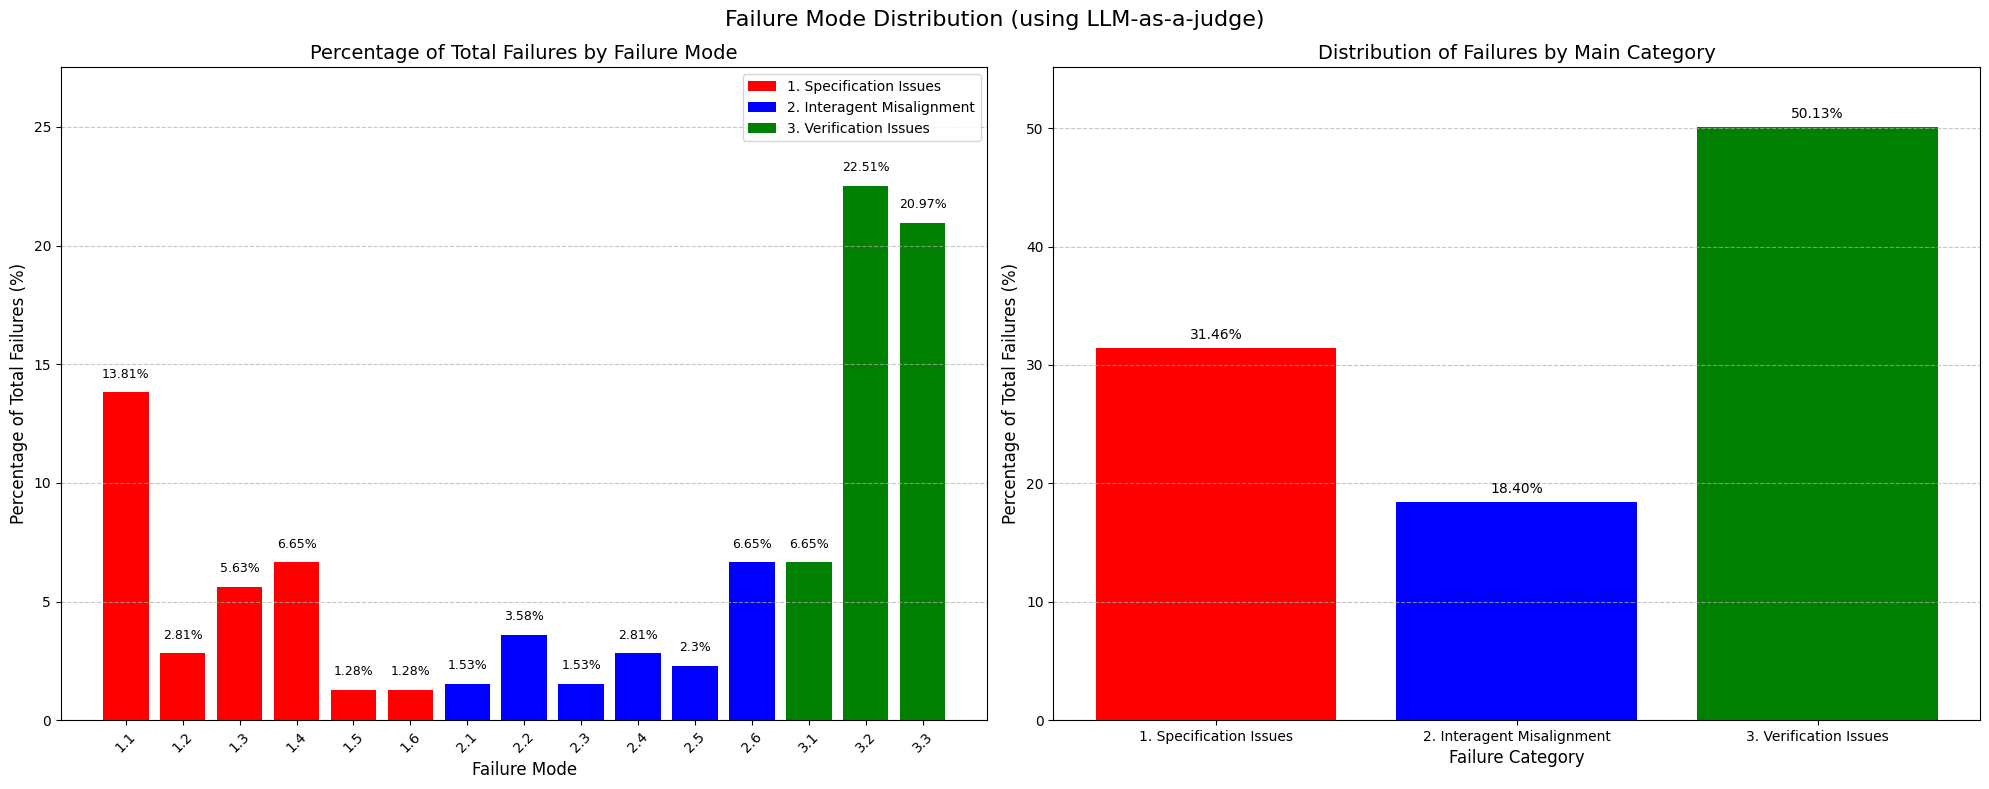


Category Statistics:
1. Specification Issues: 31.46% (based on 6 failure modes)
2. Interagent Misalignment: 18.40% (based on 6 failure modes)
3. Verification Issues: 50.13% (based on 3 failure modes)

Top 5 Most Common Failure Modes:
3.2 (3. Verification Issues): 22.51%
3.3 (3. Verification Issues): 20.97%
1.1 (1. Specification Issues): 13.81%
1.4 (1. Specification Issues): 6.65%
2.6 (2. Interagent Misalignment): 6.65%


In [25]:
failure_mode_results = failure_mode_results_o1

# Import libraries for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

# Extract the failure mode percentages from the results
failure_modes = []
percentages = []
categories = []
category_names = {
    '1': 'Specification Issues',
    '2': 'Interagent Misalignment',
    '3': 'Verification Issues'
}

# Calculate the total number of failure modes across all traces
total_failures = sum(sum(values) for mode, values in failure_mode_results.items())

for mode, values in failure_mode_results.items():
    # Calculate percentage relative to total failures instead of total traces
    percentage = round(sum(values)/total_failures*100, 2)
    failure_modes.append(mode)
    percentages.append(percentage)
    
    # Assign category based on the mode prefix
    if mode.startswith('1.'):
        categories.append(f'1. {category_names["1"]}')
    elif mode.startswith('2.'):
        categories.append(f'2. {category_names["2"]}')
    elif mode.startswith('3.'):
        categories.append(f'3. {category_names["3"]}')
    else:
        categories.append('Other')

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'Failure Mode': failure_modes,
    'Percentage': percentages,
    'Category': categories
})

# Calculate category percentages
category_percentages = df.groupby('Category')['Percentage'].sum().reset_index()
category_counts = df.groupby('Category').size().reset_index(name='Count')
category_percentages = pd.merge(category_percentages, category_counts, on='Category')

# Sort the failure modes by percentage for better visualization
# df_sorted = df.sort_values('Percentage', ascending=False)
df_sorted = df

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Bar chart of all failure modes
colors = {
    f'1. {category_names["1"]}': 'red',
    f'2. {category_names["2"]}': 'blue',
    f'3. {category_names["3"]}': 'green'
}

bars = ax1.bar(df_sorted['Failure Mode'], df_sorted['Percentage'], 
               color=[colors[cat] for cat in df_sorted['Category']])

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height}%', ha='center', va='bottom', fontsize=9)

ax1.set_title('Percentage of Total Failures by Failure Mode', fontsize=14)
ax1.set_xlabel('Failure Mode', fontsize=12)
ax1.set_ylabel('Percentage of Total Failures (%)', fontsize=12)
ax1.set_ylim(0, max(df_sorted['Percentage']) + 5)  # Add some space for the labels
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
# Plot 2: Distribution of failures across main categories
# Group failure modes by their main category (1.x, 2.x, 3.x)
main_categories = {}
for mode, percentage in zip(failure_modes, percentages):
    if mode.startswith('1.'):
        main_cat = f'1. {category_names["1"]}'
    elif mode.startswith('2.'):
        main_cat = f'2. {category_names["2"]}'
    elif mode.startswith('3.'):
        main_cat = f'3. {category_names["3"]}'
    else:
        main_cat = 'Other'
        
    if main_cat not in main_categories:
        main_categories[main_cat] = 0
    main_categories[main_cat] += percentage

# Convert to DataFrame for plotting
main_cat_df = pd.DataFrame({
    'Category': list(main_categories.keys()),
    'Total Percentage': list(main_categories.values())
})

# Sort by category name to maintain order
main_cat_df = main_cat_df.sort_values('Category')

ax2.bar(main_cat_df['Category'], main_cat_df['Total Percentage'], 
        color=[colors[cat] for cat in main_cat_df['Category']])

# Add percentage labels
for i, (cat, total) in enumerate(zip(main_cat_df['Category'], main_cat_df['Total Percentage'])):
    ax2.text(i, total + 0.5, f'{total:.2f}%', ha='center', va='bottom', fontsize=10)

ax2.set_title('Distribution of Failures by Main Category', fontsize=14)
ax2.set_xlabel('Failure Category', fontsize=12)
ax2.set_ylabel('Percentage of Total Failures (%)', fontsize=12)
ax2.set_ylim(0, max(main_cat_df['Total Percentage']) + 5)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for the first plot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label=f'1. {category_names["1"]}'),
    Patch(facecolor='blue', label=f'2. {category_names["2"]}'),
    Patch(facecolor='green', label=f'3. {category_names["3"]}')
]
ax1.legend(handles=legend_elements, loc='upper right')

fig.suptitle('Failure Mode Distribution (using LLM-as-a-judge)', fontsize=16)

plt.tight_layout()
plt.show()

# Print category statistics
print("\nCategory Statistics:")
for _, row in category_percentages.iterrows():
    print(f"{row['Category']}: {row['Percentage']:.2f}% (based on {row['Count']} failure modes)")

# Print the top 5 most common failure modes
print("\nTop 5 Most Common Failure Modes:")
for i, row in df_sorted.nlargest(5, 'Percentage').iterrows():
    print(f"{row['Failure Mode']} ({row['Category']}): {row['Percentage']}%")


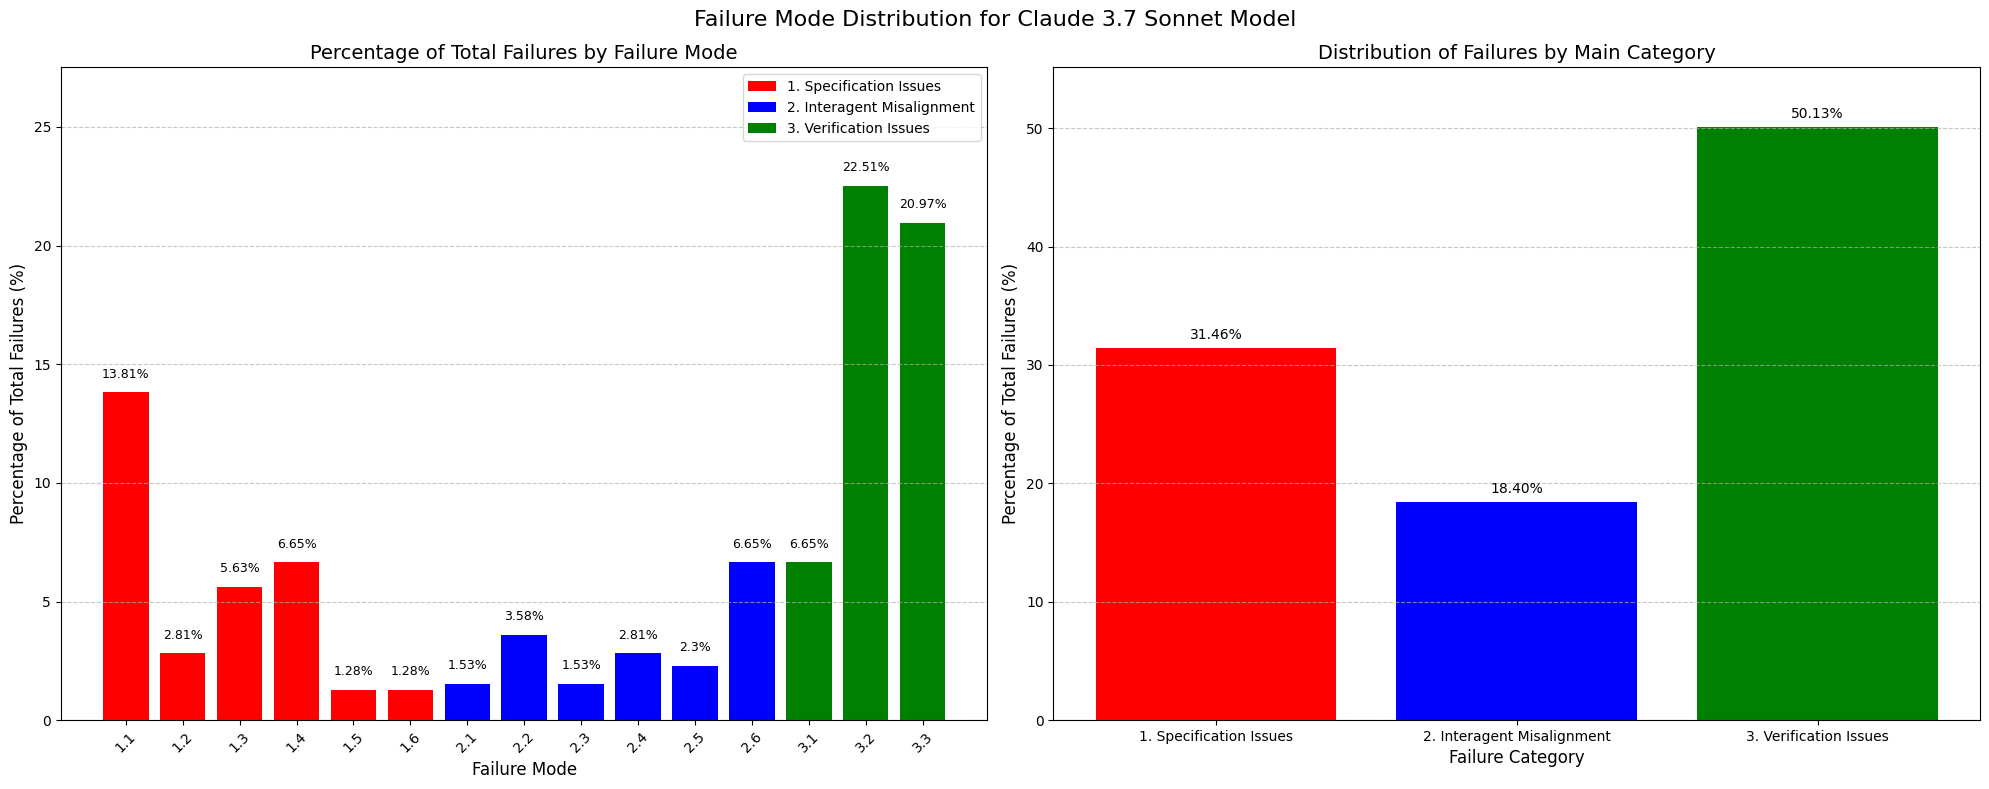


Category Statistics:
1. Specification Issues: 31.46% (based on 6 failure modes)
2. Interagent Misalignment: 18.40% (based on 6 failure modes)
3. Verification Issues: 50.13% (based on 3 failure modes)

Top 5 Most Common Failure Modes:
3.2 (3. Verification Issues): 22.51%
3.3 (3. Verification Issues): 20.97%
1.1 (1. Specification Issues): 13.81%
1.4 (1. Specification Issues): 6.65%
2.6 (2. Interagent Misalignment): 6.65%


In [26]:
failure_mode_results = failure_mode_results_claude

# Import libraries for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

# Extract the failure mode percentages from the results
failure_modes = []
percentages = []
categories = []
category_names = {
    '1': 'Specification Issues',
    '2': 'Interagent Misalignment',
    '3': 'Verification Issues'
}

# Calculate the total number of failure modes across all traces
total_failures = sum(sum(values) for mode, values in failure_mode_results.items())

for mode, values in failure_mode_results.items():
    # Calculate percentage relative to total failures instead of total traces
    percentage = round(sum(values)/total_failures*100, 2)
    failure_modes.append(mode)
    percentages.append(percentage)
    
    # Assign category based on the mode prefix
    if mode.startswith('1.'):
        categories.append(f'1. {category_names["1"]}')
    elif mode.startswith('2.'):
        categories.append(f'2. {category_names["2"]}')
    elif mode.startswith('3.'):
        categories.append(f'3. {category_names["3"]}')
    else:
        categories.append('Other')

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'Failure Mode': failure_modes,
    'Percentage': percentages,
    'Category': categories
})

# Calculate category percentages
category_percentages = df.groupby('Category')['Percentage'].sum().reset_index()
category_counts = df.groupby('Category').size().reset_index(name='Count')
category_percentages = pd.merge(category_percentages, category_counts, on='Category')

# Sort the failure modes by percentage for better visualization
# df_sorted = df.sort_values('Percentage', ascending=False)
df_sorted = df

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Bar chart of all failure modes
colors = {
    f'1. {category_names["1"]}': 'red',
    f'2. {category_names["2"]}': 'blue',
    f'3. {category_names["3"]}': 'green'
}

bars = ax1.bar(df_sorted['Failure Mode'], df_sorted['Percentage'], 
               color=[colors[cat] for cat in df_sorted['Category']])

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height}%', ha='center', va='bottom', fontsize=9)

ax1.set_title('Percentage of Total Failures by Failure Mode', fontsize=14)
ax1.set_xlabel('Failure Mode', fontsize=12)
ax1.set_ylabel('Percentage of Total Failures (%)', fontsize=12)
ax1.set_ylim(0, max(df_sorted['Percentage']) + 5)  # Add some space for the labels
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
# Plot 2: Distribution of failures across main categories
# Group failure modes by their main category (1.x, 2.x, 3.x)
main_categories = {}
for mode, percentage in zip(failure_modes, percentages):
    if mode.startswith('1.'):
        main_cat = f'1. {category_names["1"]}'
    elif mode.startswith('2.'):
        main_cat = f'2. {category_names["2"]}'
    elif mode.startswith('3.'):
        main_cat = f'3. {category_names["3"]}'
    else:
        main_cat = 'Other'
        
    if main_cat not in main_categories:
        main_categories[main_cat] = 0
    main_categories[main_cat] += percentage

# Convert to DataFrame for plotting
main_cat_df = pd.DataFrame({
    'Category': list(main_categories.keys()),
    'Total Percentage': list(main_categories.values())
})

# Sort by category name to maintain order
main_cat_df = main_cat_df.sort_values('Category')

ax2.bar(main_cat_df['Category'], main_cat_df['Total Percentage'], 
        color=[colors[cat] for cat in main_cat_df['Category']])

# Add percentage labels
for i, (cat, total) in enumerate(zip(main_cat_df['Category'], main_cat_df['Total Percentage'])):
    ax2.text(i, total + 0.5, f'{total:.2f}%', ha='center', va='bottom', fontsize=10)

ax2.set_title('Distribution of Failures by Main Category', fontsize=14)
ax2.set_xlabel('Failure Category', fontsize=12)
ax2.set_ylabel('Percentage of Total Failures (%)', fontsize=12)
ax2.set_ylim(0, max(main_cat_df['Total Percentage']) + 5)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend for the first plot
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label=f'1. {category_names["1"]}'),
    Patch(facecolor='blue', label=f'2. {category_names["2"]}'),
    Patch(facecolor='green', label=f'3. {category_names["3"]}')
]
ax1.legend(handles=legend_elements, loc='upper right')

fig.suptitle('Failure Mode Distribution for Claude 3.7 Sonnet Model', fontsize=16)

plt.tight_layout()
plt.show()

# Print category statistics
print("\nCategory Statistics:")
for _, row in category_percentages.iterrows():
    print(f"{row['Category']}: {row['Percentage']:.2f}% (based on {row['Count']} failure modes)")

# Print the top 5 most common failure modes
print("\nTop 5 Most Common Failure Modes:")
for i, row in df_sorted.nlargest(5, 'Percentage').iterrows():
    print(f"{row['Failure Mode']} ({row['Category']}): {row['Percentage']}%")


In [27]:
# Calculate interalignment between failure_mode_results_o1 and failure_mode_results_claude
def calculate_interalignment(results1, results2):
    """
    Calculate the interalignment between two sets of failure mode results.
    Returns the percentage of agreement between the two sets.
    """
    if not results1 or not results2:
        return 0
    
    # Ensure both dictionaries have the same keys
    common_keys = set(results1.keys()).intersection(set(results2.keys()))
    
    total_comparisons = 0
    total_agreements = 0
    
    for key in common_keys:
        # Get the arrays from both results
        array1 = results1[key]
        array2 = results2[key]
        
        # Make sure the arrays are the same length
        min_length = min(len(array1), len(array2))
        
        # Compare each element
        for i in range(min_length):
            total_comparisons += 1
            if array1[i] == array2[i]:
                total_agreements += 1
    
    # Calculate agreement percentage
    if total_comparisons == 0:
        return 0
    
    agreement_percentage = (total_agreements / total_comparisons) * 100
    return agreement_percentage

def calculate_cohens_kappa(results1, results2):
    """
    Calculate Cohen's Kappa score between two sets of failure mode results.
    Returns the kappa score indicating agreement beyond chance.
    """
    if not results1 or not results2:
        return 0
    
    # Ensure both dictionaries have the same keys
    common_keys = set(results1.keys()).intersection(set(results2.keys()))
    
    # Collect all observations for kappa calculation
    observations1 = []
    observations2 = []
    
    for key in common_keys:
        # Get the arrays from both results
        array1 = results1[key]
        array2 = results2[key]
        
        # Make sure the arrays are the same length
        min_length = min(len(array1), len(array2))
        
        # Collect observations
        for i in range(min_length):
            observations1.append(array1[i])
            observations2.append(array2[i])
    
    # Calculate Cohen's Kappa
    if len(observations1) == 0:
        return 0
    
    # Count agreements and calculate expected agreements by chance
    n = len(observations1)
    n_agreements = sum(1 for i in range(n) if observations1[i] == observations2[i])
    
    # Count occurrences of each category in each rater's observations
    rater1_counts = {}
    rater2_counts = {}
    
    for val in observations1:
        rater1_counts[val] = rater1_counts.get(val, 0) + 1
    
    for val in observations2:
        rater2_counts[val] = rater2_counts.get(val, 0) + 1
    
    # Calculate expected agreement by chance
    p_e = sum((rater1_counts.get(val, 0) / n) * (rater2_counts.get(val, 0) / n) 
              for val in set(observations1 + observations2))
    
    # Calculate observed agreement
    p_o = n_agreements / n
    
    # Calculate Cohen's Kappa
    if p_e == 1:  # Perfect expected agreement
        return 1.0 if p_o == 1 else 0.0
    
    kappa = (p_o - p_e) / (1 - p_e)
    return kappa

# Check if both result sets exist
if 'failure_mode_results_o1' in globals() and 'failure_mode_results_claude' in globals():
    interalignment_percentage = calculate_interalignment(
        failure_mode_results_o1, 
        failure_mode_results_claude
    )
    
    kappa_score = calculate_cohens_kappa(
        failure_mode_results_o1,
        failure_mode_results_claude
    )
    
    print(f"\nInteralignment between O1 and Claude failure mode results: {interalignment_percentage:.2f}%")
    print(f"Cohen's Kappa score: {kappa_score:.4f}")
else:
    print("\nCannot calculate interalignment: One or both result sets are missing.")



Interalignment between O1 and Claude failure mode results: 100.00%
Cohen's Kappa score: 1.0000
